In [ ]:
# -*- coding: utf-8 -*-
# 文件名: solve_problem_3_final_unified_grain_logic.py
# 功能: 最终版，将水稻逻辑统一归入粮食作物，不再单独处理

import pandas as pd
import numpy as np
import os
import re
import random
import copy
from pathlib import Path
from collections import defaultdict
from tqdm import tqdm
import multiprocessing
import time

# --- 1. 【核心配置区】 ---
NUM_CORES = 0
POP_SIZE_PER_SUBPOP = 50
NUM_POPULATIONS = 5
MAX_GEN = 100
CX_PROB = 0.8
MUT_PROB = 0.2
MIGRATION_INTERVAL = 25
MIGRATION_SIZE = 3
ELITISM_SIZE = 2
NUM_SCENARIOS = 100
YEARS = list(range(2024, 2031))

# --- [最终参数锁定] 根据灵敏度分析结果，选用产出约4300万利润的参数作为基准 ---
P_SENSITIVITY = {
    '粮食': 0.001,
    '蔬菜': 0.0015,
    '食用菌': 0.002
    # '水稻' 已移除，将自动使用'粮食'的值
}
Q_SENSITIVITY = {
    '粮食': 0.0005,
    '蔬菜': 0.0005,
    '食用菌': 0.001
    # '水稻' 已移除，将自动使用'粮食'的值
}
ALPHA_COEFFS = {k: v / 0.1 for k, v in P_SENSITIVITY.items()}
BETA_COEFFS = {k: v / 0.1 for k, v in Q_SENSITIVITY.items()}

# --- 2. 数据加载与情景生成 ---
def load_and_prepare_data(data_path):
    try:
        path_f1 = data_path / '附件1.xlsx'
        path_f2 = data_path / '附件2.xlsx'
        plots_df = pd.read_excel(path_f1, sheet_name='乡村的现有耕地')
        crops_info_df = pd.read_excel(path_f1, sheet_name='乡村种植的农作物')
        stats_df = pd.read_excel(path_f2, sheet_name='2023年统计的相关数据')
        past_planting_df = pd.read_excel(path_f2, sheet_name='2023年的农作物种植情况')
        for df in [plots_df, crops_info_df, stats_df, past_planting_df]:
            df.columns = df.columns.str.strip()
        params = {}
        params['I_plots'] = sorted(plots_df['地块名称'].tolist())
        params['P_area'] = dict(zip(plots_df['地块名称'], plots_df['地块面积/亩']))
        params['P_plot_type'] = dict(zip(plots_df['地块名称'], plots_df['地块类型']))
        
        all_crops_raw = crops_info_df['作物名称'].dropna().unique().tolist()
        params['J_crops'] = sorted([c for c in all_crops_raw if isinstance(c, str) and len(c) < 10 and '(' not in c])

        params['P_crop_type'] = dict(zip(crops_info_df['作物名称'], crops_info_df['作物类型']))
        
        # [修改] 统一粮食分类逻辑
        params['J_grain'] = [j for j in params['J_crops'] if (isinstance(params['P_crop_type'].get(j), str) and '粮食' in params['P_crop_type'].get(j, '')) or (j == '水稻')]
        params['J_vegetable'] = [j for j in params['J_crops'] if isinstance(params['P_crop_type'].get(j), str) and '蔬菜' in params['P_crop_type'].get(j, '')]
        params['J_fungus'] = [j for j in params['J_crops'] if isinstance(params['P_crop_type'].get(j), str) and '食用菌' in params['P_crop_type'].get(j, '')]
        params['J_bean'] = [j for j in params['J_crops'] if isinstance(params['P_crop_type'].get(j), str) and '豆' in params['P_crop_type'].get(j, '')]
        
        params['P_past'] = {i: {1: None, 2: None} for i in params['I_plots']}
        for _, row in past_planting_df.iterrows():
            plot, crop, season = row['种植地块'], row['作物名称'], row.get('种植季节', 1)
            if plot in params['I_plots']:
                params['P_past'][plot][season] = crop
        def clean_and_convert_price(value):
            if isinstance(value, str) and any(c in value for c in '-–—'):
                parts = re.split(r'[-–—]', value.strip())
                try: return (float(parts[0]) + float(parts[1])) / 2
                except (ValueError, IndexError): return np.nan
            return pd.to_numeric(value, errors='coerce')
        stats_df['销售单价/(元/斤)'] = stats_df['销售单价/(元/斤)'].apply(clean_and_convert_price)
        stats_df.dropna(subset=['亩产量/斤', '种植成本/(元/亩)', '销售单价/(元/斤)'], inplace=True)
        params['P_yield_base'], params['P_cost_base'], params['P_price_base'] = {}, {}, {}
        for _, row in stats_df.iterrows():
            key = (row['作物名称'], row['地块类型'])
            params['P_cost_base'][key] = row['种植成本/(元/亩)']
            params['P_yield_base'][key] = row['亩产量/斤']
            params['P_price_base'][key] = row['销售单价/(元/斤)']
        params['P_demand_base'] = {j: 0 for j in params['J_crops']}
        merged_df = pd.merge(past_planting_df, plots_df, left_on='种植地块', right_on='地块名称', how='left')
        for crop in params['J_crops']:
            crop_plantings = merged_df[merged_df['作物名称'] == crop]
            total_yield = 0
            if not crop_plantings.empty:
                for _, row in crop_plantings.iterrows():
                    area = row.get('种植面积/亩', params['P_area'][row['种植地块']])
                    yield_val = params['P_yield_base'].get((crop, row['地块类型']), 0)
                    total_yield += area * yield_val
            if total_yield == 0: total_yield = 1000
            params['P_demand_base'][crop] = total_yield
        params['S_suitability'] = defaultdict(int)
        for i in params['I_plots']:
            plot_t = params['P_plot_type'].get(i, '')
            for j in params['J_crops']:
                is_veg = j in params['J_vegetable']
                is_grain_bean = j in params['J_grain'] or j in params['J_bean']
                is_fungus = j in params['J_fungus']
                for k in [1, 2]:
                    suitable = 0
                    if plot_t in ['平旱地', '梯田', '山坡地'] and is_grain_bean and k == 1: suitable = 1
                    elif plot_t == '水浇地':
                        # 保留农学约束：水稻只能种在水浇地
                        if '水稻' in j and k == 1: suitable = 1
                        elif is_veg and (k == 1 or k == 2): suitable = 1
                    elif plot_t == '普通大棚':
                        if is_veg and k == 1: suitable = 1
                        elif is_fungus and k == 2: suitable = 1
                    elif plot_t == '智慧大棚' and is_veg and (k == 1 or k == 2): suitable = 1
                    params['S_suitability'][(i, j, k)] = suitable
        return params
    except Exception as e:
        print(f"错误: 加载数据失败: {e}"); raise

class ScenarioGenerator:
    def __init__(self, base_params):
        self.base_params = base_params
    def generate_one_scenario(self):
        scenario = { 'yield': defaultdict(dict), 'cost': defaultdict(dict), 'price': defaultdict(dict)}
        for year in YEARS:
            for key, base_yield in self.base_params['P_yield_base'].items():
                scenario['yield'][year][key] = base_yield * (1 + np.random.uniform(-0.1, 0.1))
            for key, base_cost in self.base_params['P_cost_base'].items():
                scenario['cost'][year][key] = base_cost * (1 + np.random.uniform(-0.02, 0.02))
            for key, base_price in self.base_params['P_price_base'].items():
                scenario['price'][year][key] = base_price * (1 + np.random.uniform(-0.05, 0.05))
        return scenario
    def generate_scenarios(self, num_scenarios):
        print(f"（2）[P3] 正在生成 {num_scenarios} 个基础随机情景...")
        return [self.generate_one_scenario() for _ in tqdm(range(num_scenarios), desc="生成情景")]

# --- 3. 数据预处理器 ---
class ScenarioProcessor:
    def __init__(self, scenarios, params, p_sens=None, q_sens=None):
        current_p_sens = p_sens if p_sens is not None else P_SENSITIVITY
        current_q_sens = q_sens if q_sens is not None else Q_SENSITIVITY
        current_alpha_coeffs = {k: v / 0.1 for k, v in current_p_sens.items()}
        current_beta_coeffs = {k: v / 0.1 for k, v in current_q_sens.items()}
        self.params = params; self.num_scenarios = len(scenarios)
        self.crop_map = {crop: i for i, crop in enumerate(params['J_crops'])}
        self.plot_type_map = {ptype: i for i, ptype in enumerate(set(params['P_plot_type'].values()))}
        self.year_map = {year: i for i, year in enumerate(YEARS)}
        num_crops, num_plot_types, num_years = len(self.crop_map), len(self.plot_type_map), len(self.year_map)
        shape = (self.num_scenarios, num_years, num_crops, num_plot_types)
        self.base_cost_data = np.full(shape, np.nan)
        self.base_yield_data = np.full(shape, np.nan)
        self.base_price_data = np.full(shape, np.nan)
        for s_idx, scen in enumerate(scenarios):
            for y_idx, year in enumerate(YEARS):
                for (crop, ptype), val in scen['cost'][year].items():
                    if crop in self.crop_map and ptype in self.plot_type_map: self.base_cost_data[s_idx, y_idx, self.crop_map[crop], self.plot_type_map[ptype]] = val
                for (crop, ptype), val in scen['yield'][year].items():
                    if crop in self.crop_map and ptype in self.plot_type_map: self.base_yield_data[s_idx, y_idx, self.crop_map[crop], self.plot_type_map[ptype]] = val
                for (crop, ptype), val in scen['price'][year].items():
                    if crop in self.crop_map and ptype in self.plot_type_map: self.base_price_data[s_idx, y_idx, self.crop_map[crop], self.plot_type_map[ptype]] = val
        self.base_demand_arr = np.array([params['P_demand_base'].get(c, 0) for c in self.crop_map.keys()])
        crop_type_map = {}
        # [修改] 使用 params 中预分类好的列表，不再需要特殊判断
        for crop in params['J_crops']:
            if crop in params['J_grain']: crop_type_map[crop] = '粮食'
            elif crop in params['J_vegetable']: crop_type_map[crop] = '蔬菜'
            elif crop in params['J_fungus']: crop_type_map[crop] = '食用菌'
            else: crop_type_map[crop] = '其他'
        self.alpha_arr = np.array([current_alpha_coeffs.get(crop_type_map.get(c, '粮食'), 0) for c in self.crop_map.keys()])
        self.beta_arr = np.array([current_beta_coeffs.get(crop_type_map.get(c, '粮食'), 0) for c in self.crop_map.keys()])

# --- 4. 遗传算法核心函数 ---
def create_initial_solution(params):
    solution = {y: {k: {i: None for i in params['I_plots']} for k in [1, 2]} for y in YEARS}
    for y in YEARS:
        for i in params['I_plots']:
            for k in [1, 2]:
                possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1]
                if possible_crops:
                    solution[y][k][i] = random.choice(possible_crops)
    return repair_solution(solution, params)

def repair_solution(solution, params):
    def get_crops_in_year(sol, y, i):
        crops = set()
        if y == 2023:
            for k in [1, 2]:
                crop = params['P_past'].get(i, {}).get(k)
                if crop: crops.add(crop)
        elif y in sol:
            for k in [1, 2]:
                crop = sol.get(y, {}).get(k, {}).get(i)
                if crop: crops.add(crop)
        return list(crops)
    for i in params['I_plots']:
        for y in YEARS:
            crops_last_year = get_crops_in_year(solution, y - 1, i)
            for k in [1, 2]:
                crop_this_season = solution[y][k][i]
                if crop_this_season and crop_this_season in crops_last_year:
                    possible_replacements = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1 and j not in crops_last_year]
                    solution[y][k][i] = random.choice(possible_replacements) if possible_replacements else None
    for i in params['I_plots']:
        all_years_with_past = [2023] + YEARS
        for idx in range(len(all_years_with_past) - 2):
            window = all_years_with_past[idx:idx+3]
            contains_bean = any(c in params['J_bean'] for y_win in window for c in get_crops_in_year(solution, y_win, i))
            if not contains_bean:
                y_fix = random.choice([y for y in window if y > 2023]); k_fix = 1
                crops_last_year = get_crops_in_year(solution, y_fix - 1, i)
                possible_beans = [b for b in params['J_bean'] if params['S_suitability'].get((i, b, k_fix), 0) == 1 and b not in crops_last_year]
                if possible_beans: solution[y_fix][k_fix][i] = random.choice(possible_beans)
    return solution

def crossover(p1, p2, params):
    child = copy.deepcopy(p1)
    for i in params['I_plots']:
        if random.random() < 0.5:
            for y in YEARS:
                for k in [1, 2]:
                    child[y][k][i] = p2[y][k][i]
    return child

def mutate(solution, params):
    mut_sol = copy.deepcopy(solution)
    for _ in range(random.randint(1, 5)):
        y, i, k = random.choice(YEARS), random.choice(params['I_plots']), random.choice([1, 2])
        possible_crops = [j for j in params['J_crops'] if params['S_suitability'].get((i, j, k), 0) == 1]
        if possible_crops:
            mut_sol[y][k][i] = random.choice(possible_crops)
    return mut_sol

# --- 5. 适应度函数及并行化修正 ---
processed_data_worker = None
def init_worker(processed_scenarios_data):
    global processed_data_worker
    processed_data_worker = processed_scenarios_data

def calculate_profits_vectorized(solution, params, proc_obj=None):
    proc = processed_data_worker if proc_obj is None else proc_obj
    total_production_s_y_c = np.zeros((proc.num_scenarios, len(proc.year_map), len(proc.crop_map)))
    for y_idx, y in enumerate(YEARS):
        for i in params['I_plots']:
            plot_type = params['P_plot_type'][i]; pt_idx = proc.plot_type_map[plot_type]; area = params['P_area'][i]
            for k in [1, 2]:
                crop = solution[y][k][i]
                if not crop or crop not in proc.crop_map: continue
                c_idx = proc.crop_map[crop]
                yields = proc.base_yield_data[:, y_idx, c_idx, pt_idx]
                total_production_s_y_c[:, y_idx, c_idx] += np.nan_to_num(yields) * area
    avg_annual_production_c = np.mean(total_production_s_y_c, axis=(0, 1))
    surplus_ratio = np.divide(avg_annual_production_c - 1.1 * proc.base_demand_arr, proc.base_demand_arr, 
                              out=np.zeros_like(proc.base_demand_arr, dtype=float), where=proc.base_demand_arr!=0)
    surplus_ratio = np.maximum(0, surplus_ratio)
    price_adj_factor = 1 - proc.alpha_arr * surplus_ratio
    cost_adj_factor = 1 + proc.beta_arr * surplus_ratio
    total_cost_by_scenario = np.zeros(proc.num_scenarios)
    total_production_s_c = np.sum(total_production_s_y_c, axis=1)
    for y_idx, y in enumerate(YEARS):
        for i in params['I_plots']:
            plot_type = params['P_plot_type'][i]; pt_idx = proc.plot_type_map[plot_type]; area = params['P_area'][i]
            for k in [1, 2]:
                crop = solution[y][k][i]
                if not crop or crop not in proc.crop_map: continue
                c_idx = proc.crop_map[crop]
                base_costs = proc.base_cost_data[:, y_idx, c_idx, pt_idx]
                adjusted_costs = base_costs * cost_adj_factor[c_idx]
                total_cost_by_scenario += np.nan_to_num(adjusted_costs) * area
    total_demand_7_years = proc.base_demand_arr[np.newaxis, :] * 7
    avg_base_price = np.nanmean(proc.base_price_data, axis=(1,3))
    avg_base_price[np.isnan(avg_base_price)] = 0
    adjusted_price = avg_base_price * price_adj_factor
    normal_qty = np.minimum(total_production_s_c, total_demand_7_years)
    excess_qty = total_production_s_c - normal_qty
    total_revenue_by_scenario = np.sum(normal_qty * adjusted_price + excess_qty * adjusted_price * 0.5, axis=1)
    profits = total_revenue_by_scenario - total_cost_by_scenario
    return profits

def evaluate_fitness_p3(solution, params):
    profits = calculate_profits_vectorized(solution, params)
    if np.all(np.isnan(profits)): return -1e12
    return np.nanmean(profits)

# --- 6. MPGA 运行器 ---
def run_mpga(params, pool, desc_text="MPGA进化中"):
    populations = [[create_initial_solution(params) for _ in range(POP_SIZE_PER_SUBPOP)] for _ in range(NUM_POPULATIONS)]
    best_solution_overall, best_fitness_overall = None, -np.inf
    for gen in tqdm(range(MAX_GEN), desc=desc_text):
        all_fitnesses = []
        for i in range(NUM_POPULATIONS):
            pop = populations[i]
            task_args = [(sol, params) for sol in pop]
            fitnesses = pool.starmap(evaluate_fitness_p3, task_args)
            all_fitnesses.append(fitnesses)
            best_fit_in_pop = np.max(fitnesses)
            if best_fit_in_pop > best_fitness_overall:
                best_fitness_overall = best_fit_in_pop
                best_solution_overall = copy.deepcopy(pop[np.argmax(fitnesses)])
            elite_indices = np.argsort(fitnesses)[-ELITISM_SIZE:]
            new_pop = [pop[idx] for idx in elite_indices]
            while len(new_pop) < POP_SIZE_PER_SUBPOP:
                def tournament_selection(p, f, k=3):
                    best_idx = random.randrange(len(p))
                    for _ in range(k - 1):
                        idx = random.randrange(len(p))
                        if f[idx] > f[best_idx]: best_idx = idx
                    return p[best_idx]
                p1, p2 = tournament_selection(pop, fitnesses), tournament_selection(pop, fitnesses)
                child = crossover(p1, p2, params) if random.random() < CX_PROB else copy.deepcopy(p1)
                if random.random() < MUT_PROB: child = mutate(child, params)
                new_pop.append(repair_solution(child, params))
            populations[i] = new_pop
        if gen > 0 and gen % MIGRATION_INTERVAL == 0:
            for i in range(NUM_POPULATIONS):
                target_pop_idx = (i + 1) % NUM_POPULATIONS
                best_indices_current = np.argsort(all_fitnesses[i])[-MIGRATION_SIZE:]
                migrants = [populations[i][idx] for idx in best_indices_current]
                worst_indices_target = np.argsort(all_fitnesses[target_pop_idx])[:MIGRATION_SIZE]
                for j in range(MIGRATION_SIZE):
                    populations[target_pop_idx][worst_indices_target[j]] = copy.deepcopy(migrants[j])
    return best_solution_overall, best_fitness_overall

# --- 7. 灵敏度分析通用函数 ---
def run_single_sensitivity_analysis(param_name, param_range, base_params, scenarios, pool):
    results = []
    
    for val in param_range:
        print(f"\n--- 正在测试 {param_name} = {val:.4f} ---")
        temp_p = P_SENSITIVITY.copy()
        temp_q = Q_SENSITIVITY.copy()
        
        # [修改] 简化逻辑，不再需要特殊处理水稻
        if param_name == 'p_veg': temp_p['蔬菜'] = val
        elif param_name == 'p_grain': temp_p['粮食'] = val
        elif param_name == 'p_fungi': temp_p['食用菌'] = val
        elif param_name == 'q_veg': temp_q['蔬菜'] = val
        elif param_name == 'q_grain': temp_q['粮食'] = val
        elif param_name == 'q_fungi': temp_q['食用菌'] = val
        
        proc_sens = ScenarioProcessor(scenarios, base_params, p_sens=temp_p, q_sens=temp_q)
        
        pool._initializer = init_worker
        pool._initargs = (proc_sens,)

        _, fitness = run_mpga(base_params, pool, desc_text=f"GA ({param_name}={val:.4f})")
        results.append({param_name: val, 'profit': fitness})
        print(f" -> 当 {param_name} = {val:.4f} 时, 最优利润为: {fitness:,.2f} 元")
        
    return pd.DataFrame(results)

# --- 8. 主程序入口 ---
if __name__ == '__main__':
    multiprocessing.freeze_support()
    start_time = time.time()
    num_cores_to_use = NUM_CORES if NUM_CORES and NUM_CORES > 0 else multiprocessing.cpu_count()
    print(f"--- 检测到 {multiprocessing.cpu_count()} 个CPU核心，将启动 {num_cores_to_use} 个进程 ---")
    
    try:
        project_dir = Path.cwd()
        data_path = project_dir /'Data'
        output_dir = project_dir /'5问题三'/'Result'
        output_dir.mkdir(parents=True, exist_ok=True)
        print(f"--- 问题三 MPGA 求解启动 (最终版 + 完整灵敏度分析) ---")
        
        print("\n（1）加载基础数据...")
        base_params = load_and_prepare_data(data_path)
        print(" -> 基础数据加载成功。")
        
        scenario_generator = ScenarioGenerator(base_params)
        scenarios = scenario_generator.generate_scenarios(NUM_SCENARIOS)
        print(" -> 基础情景生成成功。")
        
        # --- 基准情景运行 ---
        print("\n" + "="*50)
        print("--- Phase 1: 运行基准情景优化 (最终选定参数) ---")
        print("="*50)
        processed_scenarios_base = ScenarioProcessor(scenarios, base_params)
        init_args_base = (processed_scenarios_base,)
        
        with multiprocessing.Pool(processes=num_cores_to_use, initializer=init_worker, initargs=init_args_base) as pool:
            best_solution, best_fitness = run_mpga(base_params, pool, desc_text="基准情景GA进化")
        
            print(f"\n求解完成。")
            print(f" -> 最优方案预期平均利润: {best_fitness:,.2f} 元")

            if best_solution:
                print("\n--- 开始为基准情景生成可视化所需的数据文件 ---")
                
                chart1_data = []
                for crop_type in ['粮食', '蔬菜', '食用菌']:
                    chart1_data.append({'作物类别': crop_type, '系数类型': '价格敏感度α', '系数值': -ALPHA_COEFFS[crop_type]})
                    chart1_data.append({'作物类别': crop_type, '系数类型': '成本敏感度β', '系数值': BETA_COEFFS[crop_type]})
                chart1_df = pd.DataFrame(chart1_data)
                chart1_path = output_dir / 'chart1_sensitivity_coefficients.csv'
                chart1_df.to_csv(chart1_path, index=False, encoding='utf-8-sig')
                print(f" -> 图表1数据已保存至: {chart1_path}")

                output_list = []
                crop_type_map = {}
                # [修改] 使用 params 中预分类好的列表，不再需要特殊判断
                for crop in base_params['J_crops']:
                    if crop in base_params['J_grain']: crop_type_map[crop] = '粮食作物'
                    elif crop in base_params['J_vegetable']: crop_type_map[crop] = '蔬菜'
                    elif crop in base_params['J_fungus']: crop_type_map[crop] = '食用菌'
                    else: crop_type_map[crop] = '其他'

                for y in sorted(best_solution.keys()):
                    for k in sorted(best_solution[y].keys()):
                        for i in sorted(best_solution[y][k].keys()):
                            crop = best_solution[y][k][i]
                            if crop:
                                output_list.append({
                                    '年份': y, '季节': k, '地块编号': i, 
                                    '地块类型': base_params['P_plot_type'][i],
                                    '作物名称': crop, '作物类别': crop_type_map.get(crop, '其他'),
                                    '种植面积（亩）': base_params['P_area'][i]
                                })
                result_df = pd.DataFrame(output_list)
                
                chart2_df = result_df.groupby(['年份', '作物类别'])['种植面积（亩）'].sum().reset_index()
                chart2_path = output_dir / 'chart2_annual_area.csv'
                chart2_df.to_csv(chart2_path, index=False, encoding='utf-8-sig')
                print(f" -> 图表2数据已保存至: {chart2_path}")

                chart3_path = output_dir / '问题三最优种植策略_chart3_data.xlsx'
                result_df.to_excel(chart3_path, index=False)
                print(f" -> 图表3数据已保存至: {chart3_path}")
                
                final_profits = calculate_profits_vectorized(best_solution, base_params, proc_obj=processed_scenarios_base)
                chart4_df = pd.DataFrame(final_profits, columns=['Profit'])
                chart4_path = output_dir / 'chart4_profit_distribution.csv'
                chart4_df.to_csv(chart4_path, index=False)
                print(f" -> 图表4数据已保存至: {chart4_path}")
                
                mean_profit = np.mean(final_profits)
                p5 = np.percentile(final_profits, 5)
                p95 = np.percentile(final_profits, 95)
                print("\n--- 图表四关键统计值 ---")
                print(f"预期平均利润: {mean_profit:,.2f} 元")
                print(f"5%分位点 (最差5%情况): {p5:,.2f} 元")
                print(f"95%分位点 (最好5%情况): {p95:,.2f} 元")
                print("--------------------------")
            else:
                print("未能找到有效解。")

            # --- [扩展] 完整的灵敏度分析模块 ---
            print("\n" + "="*50)
            print("--- Phase 2: 开始运行完整的灵敏度分析 ---")
            print("重要提示: 此过程将多次运行GA，总耗时会很长。")
            print("="*50 + "\n")

            sensitivity_tasks = {
                'p_veg':   [0.0015, 0.0125, 0.025, 0.05],
                'p_fungi': [0.002,  0.0125, 0.025, 0.05],
                'p_grain': [0.001,  0.005,  0.01,  0.02],
                'q_veg':   [0.0005, 0.0025, 0.005, 0.01],
                'q_fungi': [0.001,  0.0075, 0.015, 0.03],
                'q_grain': [0.0005, 0.0025, 0.005, 0.01],
            }
            
            chart_counter = 5
            for param_name, param_range in sensitivity_tasks.items():
                results_df = run_single_sensitivity_analysis(param_name, param_range, base_params, scenarios, pool)
                chart_path = output_dir / f'chart{chart_counter}_sensitivity_analysis_{param_name}.csv'
                results_df.to_csv(chart_path, index=False, encoding='utf-8-sig')
                print(f"\n -> {param_name} 灵敏度分析完成，数据已保存至: {chart_path}")
                chart_counter += 1

    except FileNotFoundError:
        print(f"\n错误：文件未找到。请检查您的项目文件夹内是否包含 'Data' 子文件夹，且附件1和2在其中。")
    except Exception as e:
        print(f"\n程序主流程发生严重错误: {e}")
        import traceback
        traceback.print_exc()
    finally:
        end_time = time.time()
        print(f"\n程序总运行时间: {(end_time - start_time) / 60:.2f} 分钟")

--- 检测到 16 个CPU核心，将启动 16 个进程 ---
--- 问题三 MPGA 求解启动 (最终版 + 完整灵敏度分析) ---

（1）加载基础数据...
 -> 基础数据加载成功。
（2）[P3] 正在生成 100 个基础随机情景...


生成情景: 100%|██████████| 100/100 [00:00<00:00, 177.19it/s]


 -> 基础情景生成成功。

--- Phase 1: 运行基准情景优化 (最终选定参数) ---


图像已保存至: Result/图表1_敏感度系数设定图.png


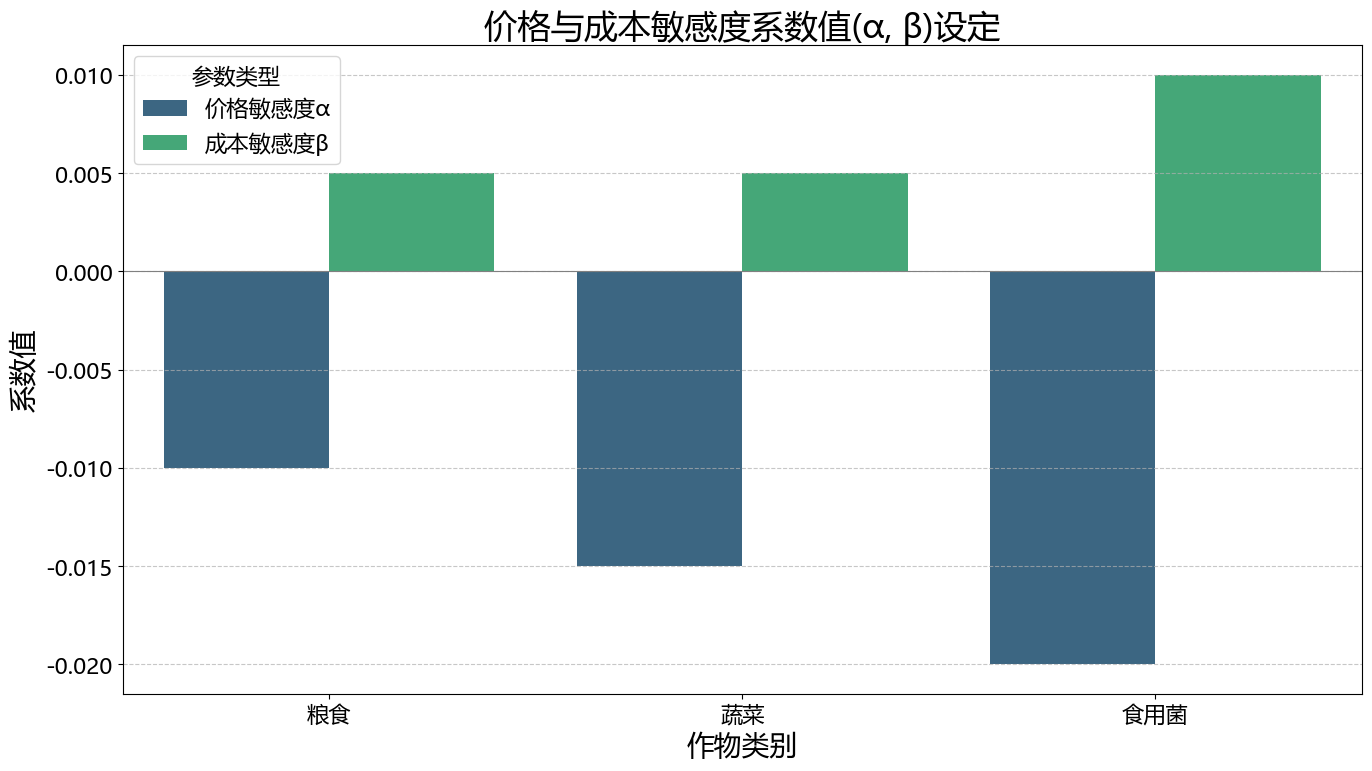

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# --- 绘图配置 ---
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20

# --- 数据加载 ---
try:
    df = pd.read_csv('Result/chart1_sensitivity_coefficients.csv')

    # --- 绘图 ---
    plt.figure(figsize=(14, 8))
    sns.barplot(data=df, x='作物类别', y='系数值', hue='系数类型', palette='viridis')
    plt.title('价格与成本敏感度系数值(α, β)设定')
    plt.xlabel('作物类别')
    plt.ylabel('系数值')
    plt.axhline(0, color='grey', linewidth=0.8)
    plt.legend(title='参数类型')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig("Result/图表1_敏感度系数设定图.png", dpi=300)
    print("图像已保存至: Result/图表1_敏感度系数设定图.png")

except FileNotFoundError:
    print("错误: 未找到 'Result/chart1_sensitivity_coefficients.csv' 文件。")

AttributeError: Line2D.set() got an unexpected keyword argument 'edgecolor'

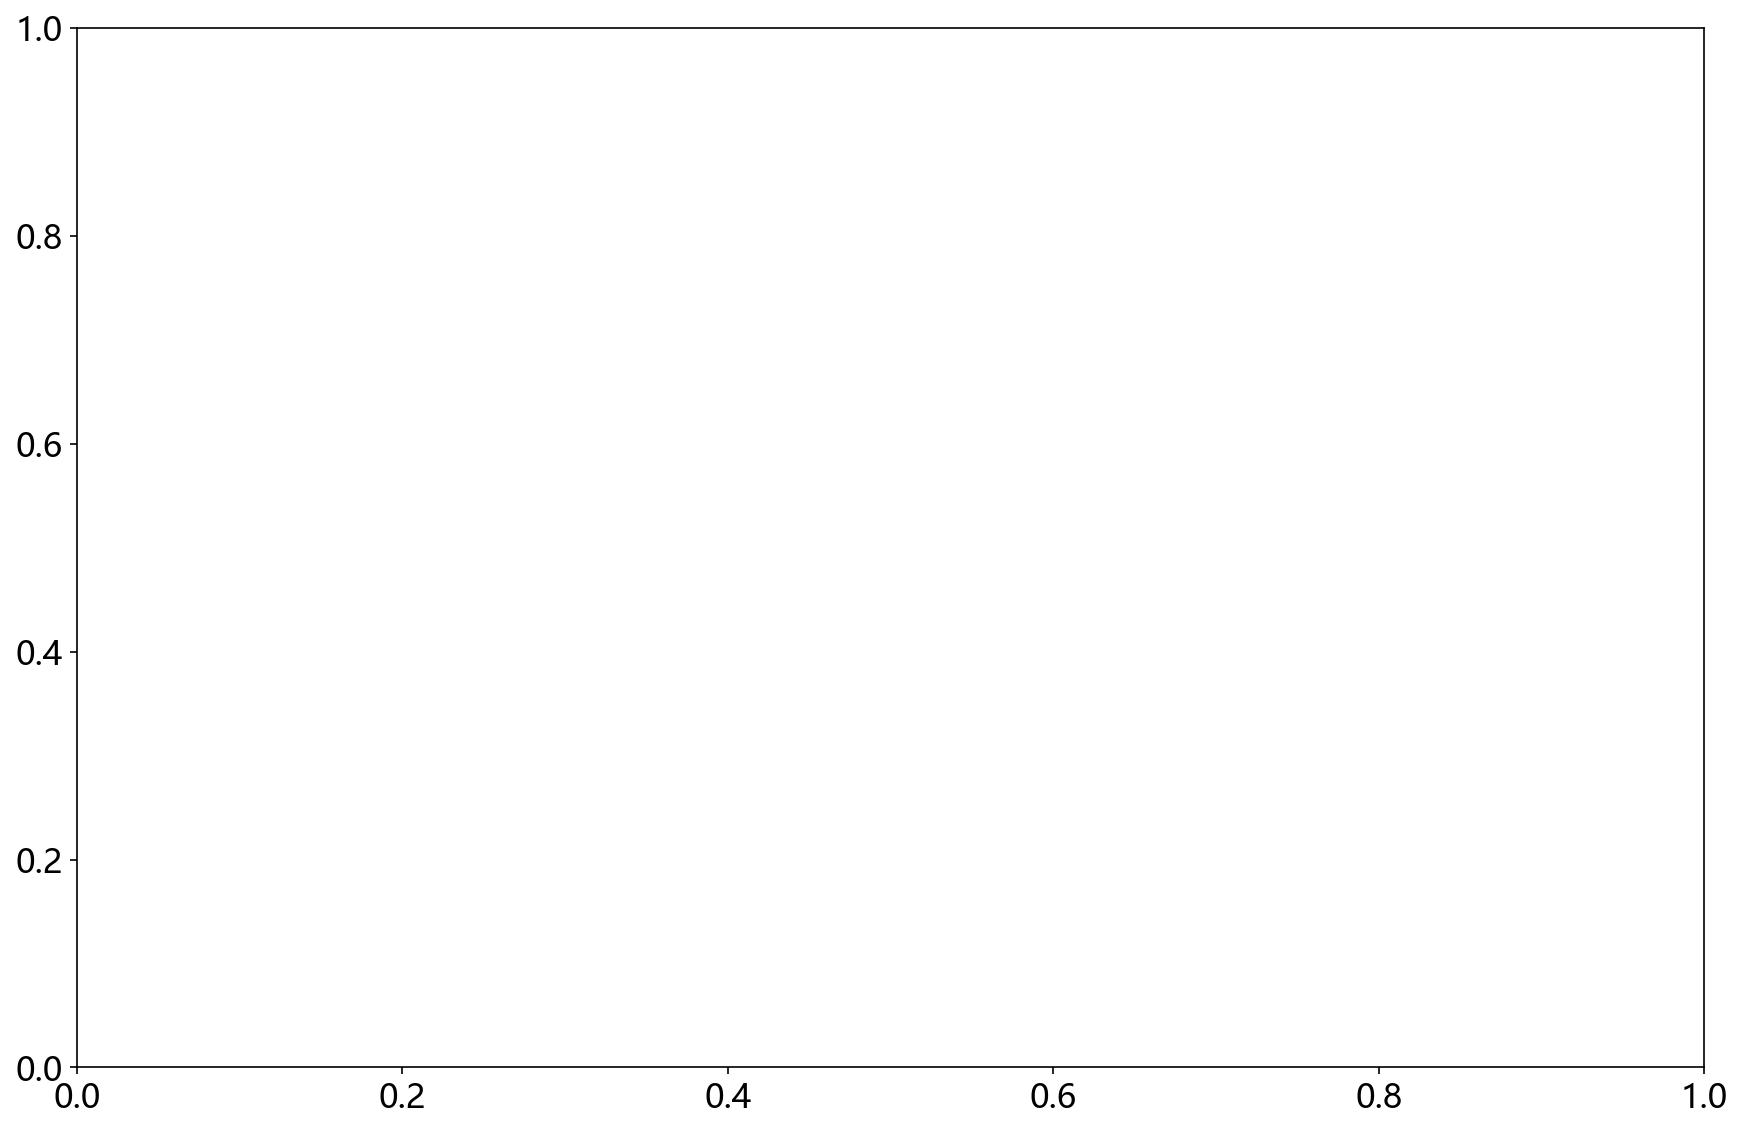

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path

# =============================================================================
# 1. 环境与数据准备
# =============================================================================

# 沿用您偏好的绘图配置：设置中文字体、大字号
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20

# --- 模拟数据生成 ---
years = np.arange(2024, 2031)
data = []
# 增加了数据的波动性，使示意图更生动
grain_area = 850 - np.linspace(0, 50, len(years)) + np.random.uniform(-20, 20, len(years))
veg_area = 350 + np.linspace(0, 80, len(years)) + np.random.uniform(-25, 25, len(years))
fungi_area = np.full(len(years), 9.6) + np.random.uniform(-2, 2, len(years))

for i, year in enumerate(years):
    data.append({'年份': year, '作物类别': '粮食作物', '种植面积（亩）': grain_area[i]})
    data.append({'年份': year, '作物类别': '蔬菜', '种植面积（亩）': veg_area[i]})
    data.append({'年份': year, '作物类别': '食用菌', '种植面积（亩）': fungi_area[i]})

mock_df = pd.DataFrame(data)

# =============================================================================
# 2. 数据透视与颜色配置
# =============================================================================

# --- 数据处理 ---
pivot_df = mock_df.pivot(index='年份', columns='作物类别', values='种植面积（亩）').fillna(0)
# 为了让颜色和作物类别正确对应，我们固定列的顺序
column_order = ['粮食作物', '蔬菜', '食用菌']
pivot_df = pivot_df[column_order]

# --- 配色方案选择 ---
# 方案二：自然田野 (您推荐的方案)
# 颜色分别对应：粮食作物(棕黄)、蔬菜(浅绿)、食用菌(深灰)
colors = ['#d8b365', '#a6dba0', '#525252']

# =============================================================================
# 3. 核心绘图与美化
# =============================================================================

fig, ax = plt.subplots(figsize=(14, 9))

# --- 绘制堆叠面积图 ---
pivot_df.plot(kind='area',
              stacked=True,
              ax=ax,
              alpha=0.85,      # 稍微增加不透明度，使颜色更饱满
              color=colors,
              linewidth=1.5,     # 增加线条宽度
              edgecolor='white')

# --- [美化] 添加总计数据标签 ---
# 计算每年的总和
totals = pivot_df.sum(axis=1)
for i, total in enumerate(totals):
    ax.text(totals.index[i], total + 10, f'{total:,.0f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# --- [美化] 优化坐标轴和网格线 ---
ax.set_title('最优策略下各类作物总种植面积年度趋势 (示意图)', pad=20)
ax.set_xlabel('年份', labelpad=15)
ax.set_ylabel('总种植面积 (亩)', labelpad=15)
ax.grid(True, linestyle='--', alpha=0.5) # 网格线更柔和

# 设置Y轴刻度格式为千位分隔符
ax.yaxis.set_major_formatter(mticker.StrMethodFormatter('{x:,.0f}'))

# [美化] 移除顶部和右侧的边框线，使图表更简洁
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# --- 调整图例和刻度 ---
ax.legend(title='作物类别', bbox_to_anchor=(1.02, 1), loc='upper left', fontsize=14)
plt.xticks(pivot_df.index, rotation=0) # 确保年份标签是水平的
ax.set_ylim(0, totals.max() * 1.15) # 调整Y轴上限，为数据标签留出空间

# 自动调整布局以防止标签重叠
plt.tight_layout(rect=[0, 0, 0.88, 1]) # 为外部图例留出右侧空间

# =============================================================================
# 4. 保存图像
# =============================================================================
output_dir = Path("Result")
output_dir.mkdir(exist_ok=True)
# [美化] 保存时使用 bbox_inches='tight' 以确保所有元素（如图例）都被完整保存
file_path = output_dir / "最终美化版_年度种植面积堆叠图.png"
plt.savefig(file_path, dpi=300, bbox_inches='tight')

print(f"图像已成功保存至: {file_path}")

图像已保存至: Result/图表3_典型地块种植计划图.png


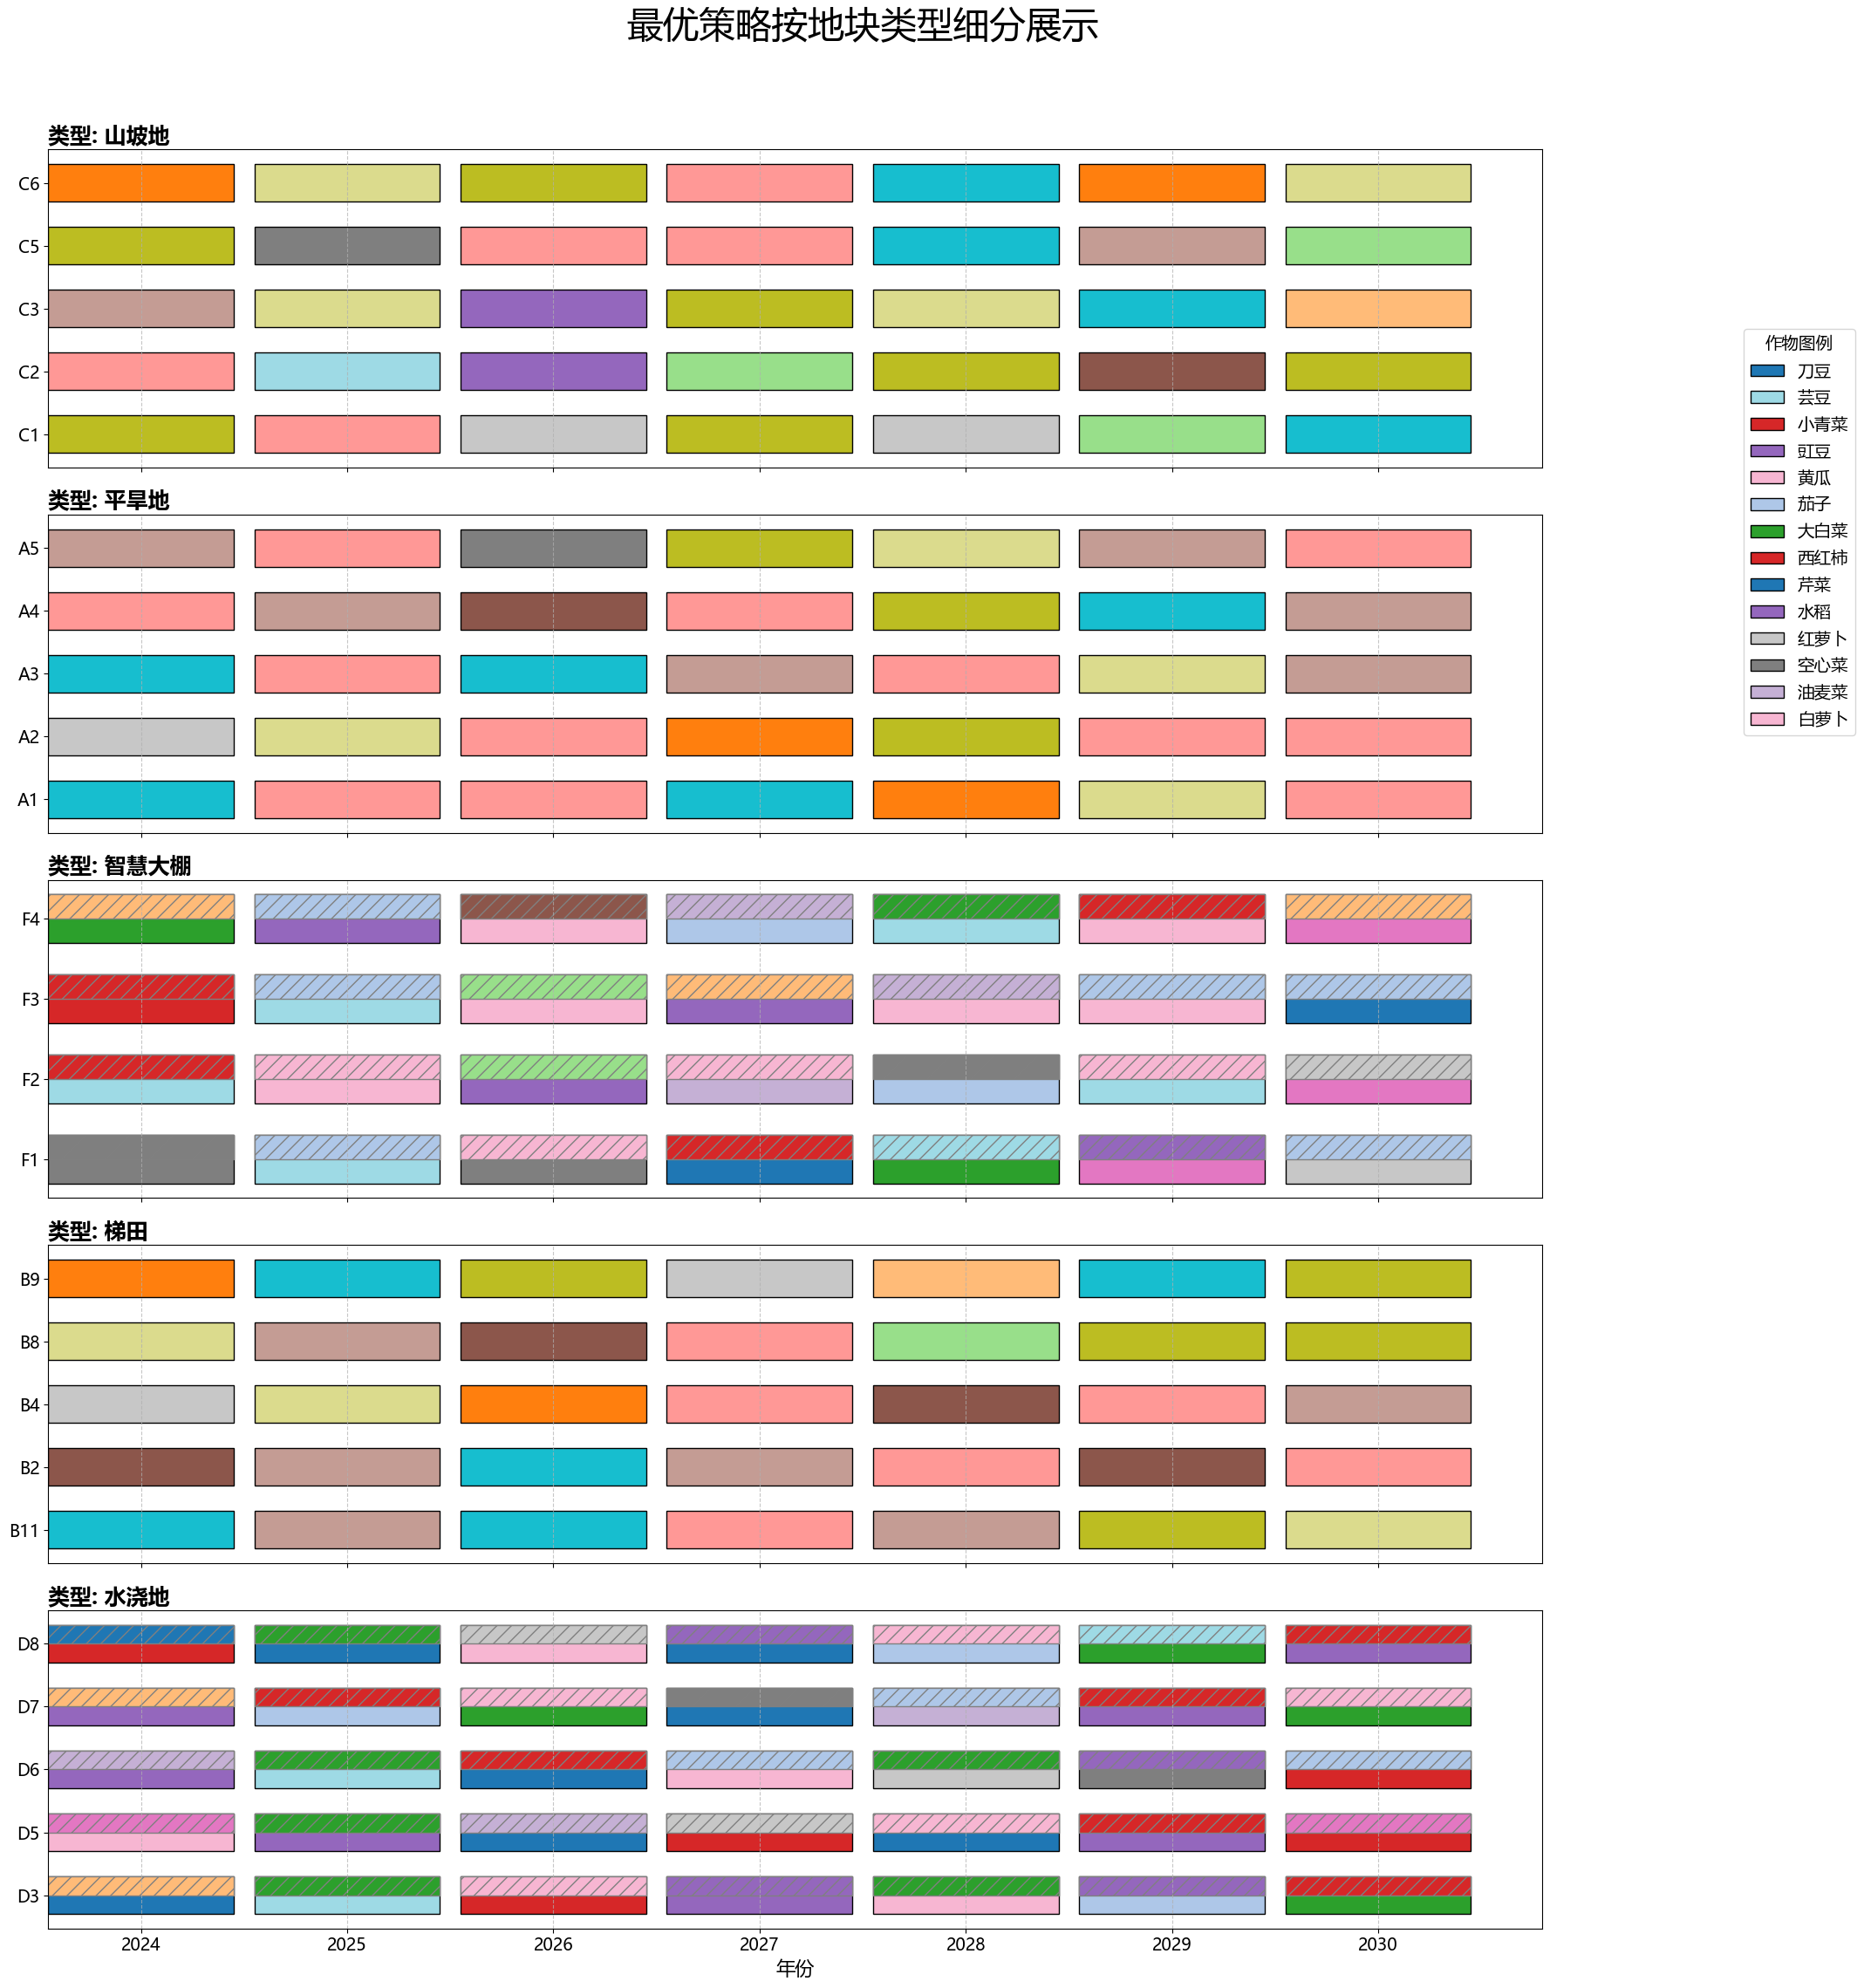

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 绘图配置 ---
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

# --- 数据加载 ---
try:
    df = pd.read_excel('Result/问题三最优种植策略_chart3_data.xlsx')
    
    unique_crops = sorted(df['作物名称'].unique())
    colors = sns.color_palette("tab20", len(unique_crops))
    crop_to_color = {crop: colors[i] for i, crop in enumerate(unique_crops)}

    plot_types = sorted(df['地块类型'].unique())
    fig, axes = plt.subplots(len(plot_types), 1, figsize=(20, 24), sharex=True)
    fig.suptitle('最优策略按地块类型细分展示', fontsize=30, y=0.95)

    for ax, plot_type in zip(axes, plot_types):
        df_type = df[df['地块类型'] == plot_type]
        plots_in_type = sorted(df_type['地块编号'].unique())
        plots_to_show = np.random.choice(plots_in_type, min(5, len(plots_in_type)), replace=False)
        df_subset = df_type[df_type['地块编号'].isin(plots_to_show)]
        y_ticks = sorted(plots_to_show)
        y_tick_pos = np.arange(len(y_ticks))
        for i, plot_name in enumerate(y_ticks):
            plot_df = df_subset[df_subset['地块编号'] == plot_name]
            for _, row in plot_df.iterrows():
                year, season, crop = row['年份'], row['季节'], row['作物名称']
                if season == 1:
                    ax.barh(y=i, width=0.9, left=year - 0.45, height=0.6, 
                            color=crop_to_color.get(crop, 'grey'), edgecolor='black', label=crop)
                else:
                    ax.barh(y=i, width=0.9, left=year - 0.45, height=0.3, align='edge',
                            color=crop_to_color.get(crop, 'grey'), edgecolor='grey', hatch='//')
        ax.set_yticks(y_tick_pos)
        ax.set_yticklabels(y_ticks, fontdict={'fontsize': 14})
        ax.set_title(f'类型: {plot_type}', loc='left', fontsize=18, fontweight='bold')
        ax.grid(axis='x', linestyle='--', alpha=0.7)

    plt.xticks(sorted(df['年份'].unique()))
    axes[-1].set_xlabel('年份')
    handles, labels = fig.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), bbox_to_anchor=(1.0, 0.7), loc='center left', title='作物图例', fontsize=14)
    plt.tight_layout(rect=[0, 0, 0.9, 0.93])
    plt.savefig("Result/图表3_典型地块种植计划图.png", dpi=300)
    print("图像已保存至: Result/图表3_典型地块种植计划图.png")

except FileNotFoundError:
    print("错误: 未找到 'Result/问题三最优种植策略_chart3_data.xlsx' 文件。")

图像已保存至: Result/图表4_最终方案利润分布图.png


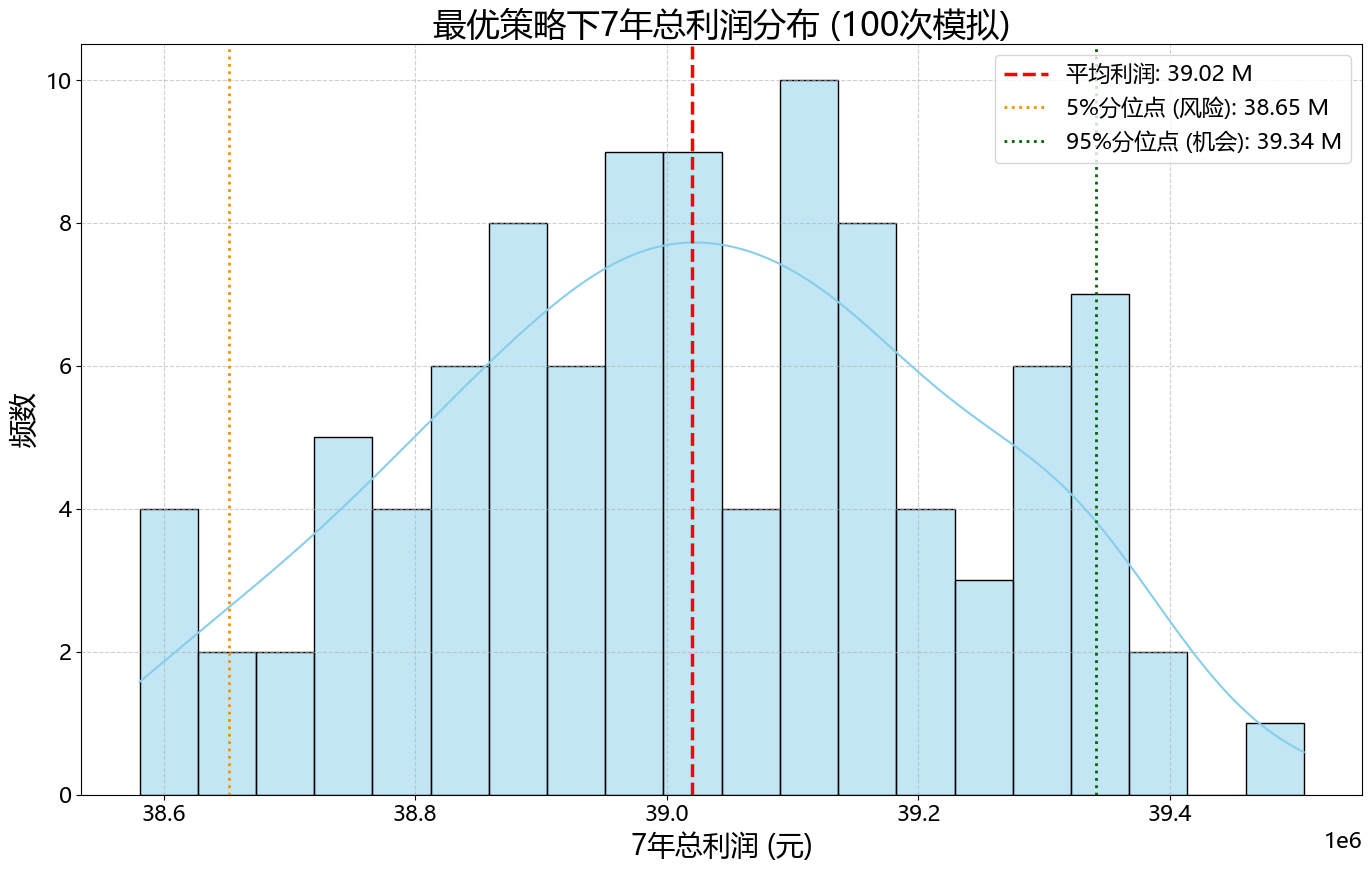

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# --- 绘图配置 ---
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 20

# --- 数据加载 ---
try:
    profits_df = pd.read_csv('Result/chart4_profit_distribution.csv')
    profits = profits_df['Profit']

    # --- 从您的运行结果日志中获取精确的统计值 ---
    mean_profit = 39020501.59
    p5 = 38651785.03
    p95 = 39341535.57

    # --- 绘图 ---
    plt.figure(figsize=(14, 9))
    sns.histplot(profits, kde=True, bins=20, color='skyblue', edgecolor='black')
    
    plt.axvline(mean_profit, color='red', linestyle='--', linewidth=2.5, label=f'平均利润: {mean_profit/1e6:.2f} M')
    plt.axvline(p5, color='darkorange', linestyle=':', linewidth=2, label=f'5%分位点 (风险): {p5/1e6:.2f} M')
    plt.axvline(p95, color='darkgreen', linestyle=':', linewidth=2, label=f'95%分位点 (机会): {p95/1e6:.2f} M')
    
    plt.title('最优策略下7年总利润分布 (100次模拟)')
    plt.xlabel('7年总利润 (元)')
    plt.ylabel('频数')
    plt.ticklabel_format(style='sci', axis='x', scilimits=(6,6))
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.savefig("Result/图表4_最终方案利润分布图.png", dpi=300)
    print("图像已保存至: Result/图表4_最终方案利润分布图.png")

except FileNotFoundError:
    print("错误: 未找到 'Result/chart4_profit_distribution.csv' 文件。")

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

# --- 绘图配置 ---
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei', 'SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['font.size'] = 14
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.labelsize'] = 16

# --- 定义基准参数 (与您主程序中的设定一致) ---
BASE_P_SENSITIVITY = {'粮食': 0.001, '蔬菜': 0.0015, '食用菌': 0.002}
BASE_Q_SENSITIVITY = {'粮食': 0.0005, '蔬菜': 0.0005, '食用菌': 0.001}

# --- 定义要加载和绘制的任务 ---
sensitivity_tasks = {
    'alpha': [
        {'file': 'chart7_sensitivity_analysis_p_grain.csv', 'x_col': 'p_grain', 'label': r'$\alpha_{粮食}$', 'base': BASE_P_SENSITIVITY['粮食']},
        {'file': 'chart5_sensitivity_analysis_p_veg.csv',   'x_col': 'p_veg',   'label': r'$\alpha_{蔬菜}$', 'base': BASE_P_SENSITIVITY['蔬菜']},
        {'file': 'chart6_sensitivity_analysis_p_fungi.csv', 'x_col': 'p_fungi', 'label': r'$\alpha_{食用菌}$', 'base': BASE_P_SENSITIVITY['食用菌']}
    ],
    'beta': [
        {'file': 'chart10_sensitivity_analysis_q_grain.csv','x_col': 'q_grain', 'label': r'$\beta_{粮食}$', 'base': BASE_Q_SENSITIVITY['粮食']},
        {'file': 'chart8_sensitivity_analysis_q_veg.csv',   'x_col': 'q_veg',   'label': r'$\beta_{蔬菜}$', 'base': BASE_Q_SENSITIVITY['蔬菜']},
        {'file': 'chart9_sensitivity_analysis_q_fungi.csv', 'x_col': 'q_fungi', 'label': r'$\beta_{食用菌}$', 'base': BASE_Q_SENSITIVITY['食用菌']}
    ]
}

# --- 数据加载与预处理 ---
all_dfs = []
data_found = False
result_dir = Path("Result")

for param_type, tasks in sensitivity_tasks.items():
    for task in tasks:
        file_path = result_dir / task['file']
        if file_path.exists():
            df = pd.read_csv(file_path)
            # 计算变化百分比
            df['change_pct'] = (df[task['x_col']] / task['base'] - 1) * 100
            df['param_type'] = task['label']
            df['type'] = param_type
            all_dfs.append(df)
            data_found = True
        else:
            print(f"警告: 未找到文件 {file_path}，将跳过该参数。")

# --- [核心修正] 只有在成功加载数据后才进行绘图 ---
if not data_found:
    print("\n错误：未能加载任何灵敏度分析数据，无法绘图。")
    print("请确认：\n1. 您的主求解程序已成功运行到最后。\n2. 本脚本与'Result'文件夹位于同一目录下。")
else:
    full_df = pd.concat(all_dfs)
    
    # --- 绘图 (1x2 子图) ---
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 9))
    fig.suptitle('价格与成本敏感度对比分析', fontsize=28, y=0.98)

    # 子图1: 价格敏感度 (Alpha)
    df_alpha = full_df[full_df['type'] == 'alpha']
    sns.lineplot(data=df_alpha, x='change_pct', y='profit', hue='param_type', 
                 marker='o', ax=ax1, linewidth=2.5)
    ax1.set_title('价格敏感度 ($\alpha$) 分析')
    ax1.set_xlabel('参数值与基准值的变化 (%)')
    ax1.set_ylabel('预期平均利润 (元)')
    ax1.ticklabel_format(style='sci', axis='y', scilimits=(6,6))
    ax1.grid(True, linestyle='--', alpha=0.6)
    ax1.legend(title='参数')

    # 子图2: 成本敏感度 (Beta)
    df_beta = full_df[full_df['type'] == 'beta']
    sns.lineplot(data=df_beta, x='change_pct', y='profit', hue='param_type', 
                 marker='s', ax=ax2, linewidth=2.5)
    ax2.set_title('成本敏感度 ($\beta$) 分析')
    ax2.set_xlabel('参数值与基准值的变化 (%)')
    ax2.set_ylabel('') # 隐藏Y轴标签以保持整洁
    ax2.ticklabel_format(style='sci', axis='y', scilimits=(6,6))
    ax2.grid(True, linestyle='--', alpha=0.6)
    ax2.legend(title='参数')
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig("Result/整合版灵敏度分析图.png", dpi=300)
    print("\n图像已成功保存至: Result/整合版灵敏度分析图.png")

ValueError: 
价格敏感度 ($lpha$) 分析
       ^
ParseException: Expected end of text, found '$'  (at char 7), (line:1, col:8)

Error in callback <function _draw_all_if_interactive at 0x000001F93755B420> (for post_execute), with arguments args (),kwargs {}:


ValueError: 
价格敏感度 ($lpha$) 分析
       ^
ParseException: Expected end of text, found '$'  (at char 7), (line:1, col:8)

ValueError: 
价格敏感度 ($lpha$) 分析
       ^
ParseException: Expected end of text, found '$'  (at char 7), (line:1, col:8)

<Figure size 3000x1350 with 2 Axes>

正在加载数据...
横轴作物排序完成。
筛选并处理2024年数据...
开始绘制最终版热力图...


C:\Users\86185\AppData\Local\Temp\ipykernel_7932\116710548.py:48: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  sort_df['类型'].fillna('其他', inplace=True)
C:\Users\86185\AppData\Local\Temp\ipykernel_7932\116710548.py:82: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  original_cmap = cm.get_cmap('YlGn')
C:\Users\86185\AppData\Local\Temp\ipykernel_7932\1167


图表已成功保存至: Result\2024年最优种植方案.png


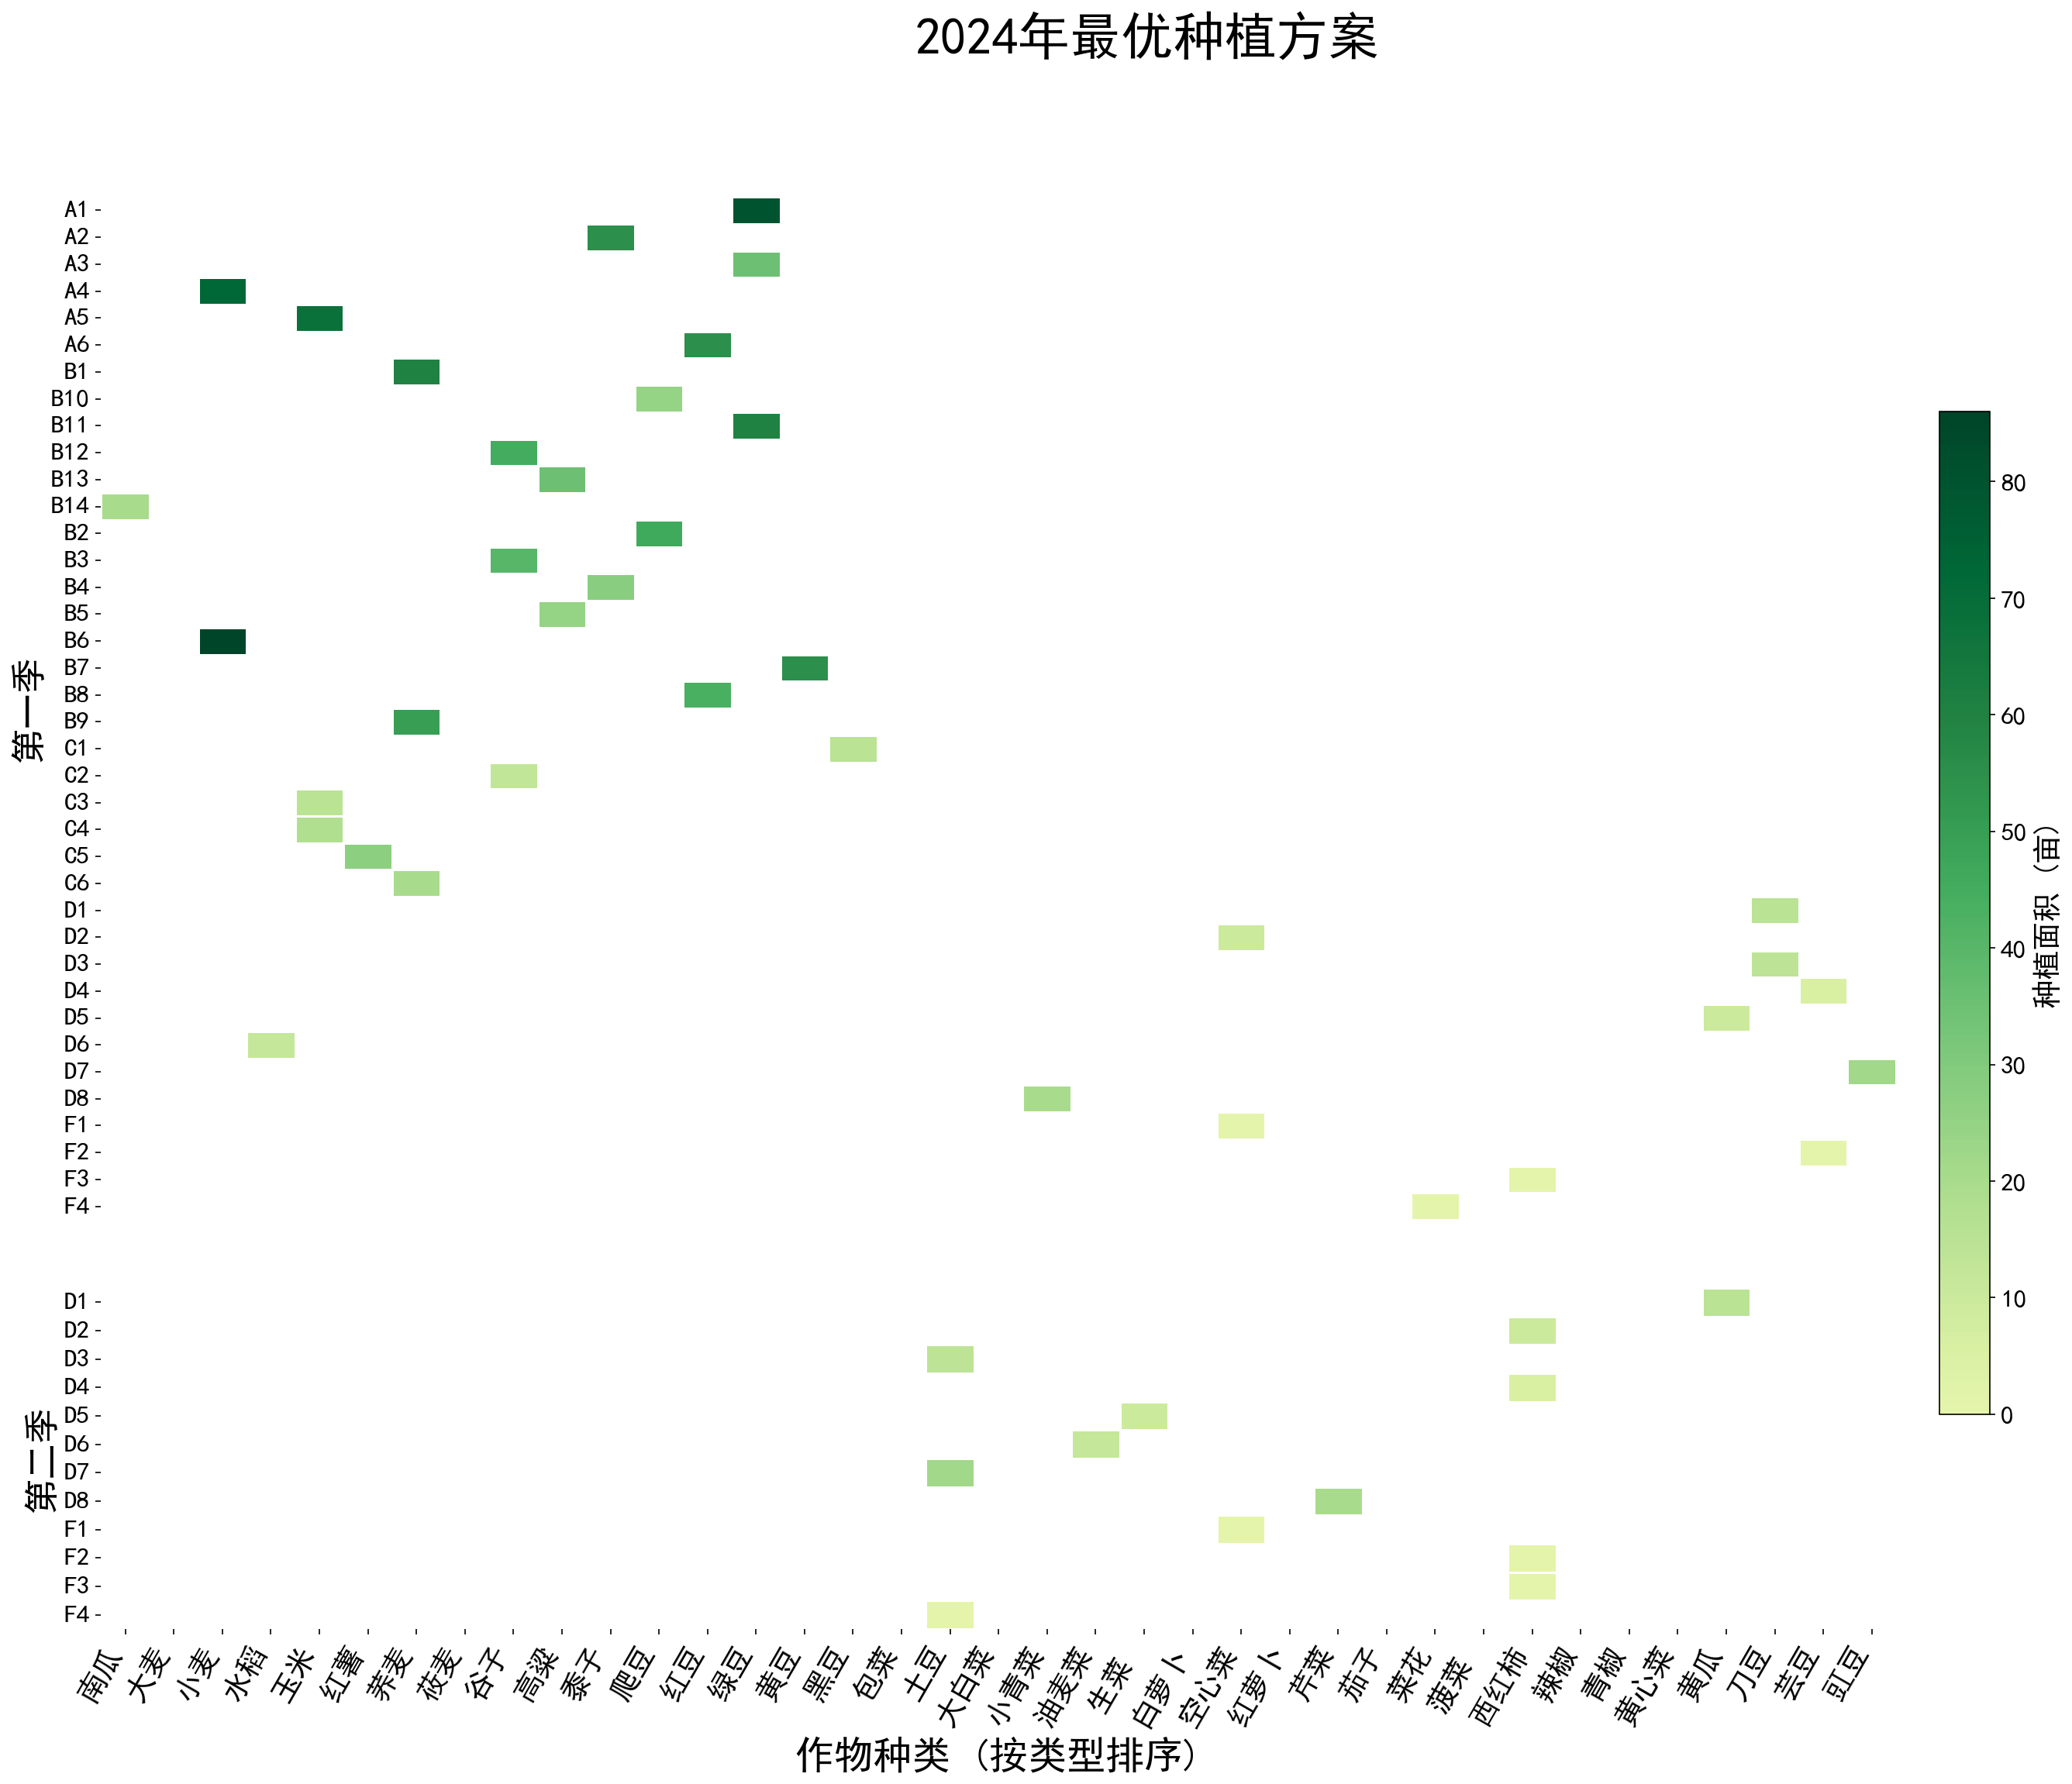

In [ ]:
# -*- coding: utf-8 -*-
# 文件名: plot_discrete_heatmap_final_polished_v3.py
# 功能: 修正中间出现X轴标签的布局问题。

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

# --- 1. 绘图与文件路径配置 ---

# 设置绘图风格以符合学术审美
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.dpi'] = 150

# 定义大字号
SUPTITLE_FONT_SIZE = 32
LABEL_FONT_SIZE = 24
YLABEL_FONT_SIZE = 22
CBAR_LABEL_FONT_SIZE = 18
XTICK_FONT_SIZE = 18
YTICK_FONT_SIZE = 16


# --- 文件路径定义 ---
INPUT_RESULT_XLSX = Path('./Result/问题三最优种植策略_chart3_data.xlsx')
INPUT_ATTACHMENT_XLSX = Path('../Data/附件1.xlsx')
OUTPUT_IMAGE_PATH = Path('./Result/2024年最优种植方案.png')


# --- 2. 数据加载与核心解析 ---

try:
    print("正在加载数据...")
    full_df = pd.read_excel(INPUT_RESULT_XLSX)
    crop_types_df = pd.read_excel(INPUT_ATTACHMENT_XLSX, sheet_name='乡村种植的农作物')

    # --- 根据作物类型进行智能排序 ---
    crop_to_type_map = dict(zip(crop_types_df['作物名称'], crop_types_df['作物类型']))
    all_crops_in_data = sorted(full_df['作物名称'].unique())
    sort_df = pd.DataFrame({'作物': all_crops_in_data})
    sort_df['类型'] = sort_df['作物'].map(crop_to_type_map)
    sort_df['类型'].fillna('其他', inplace=True)
    sort_df.sort_values(by=['类型', '作物'], inplace=True)
    all_crops_master_list = sort_df['作物'].tolist()
    print("横轴作物排序完成。")

    # --- 数据筛选与准备 ---
    print("筛选并处理2024年数据...")
    df = full_df[full_df['年份'] == 2024].copy()
    
    if df.empty:
        print("错误：在文件中没有找到年份为 2024 的数据记录。")
    else:
        df.rename(columns={'地块编号': '地块', '作物名称': '作物', '种植面积（亩）': '面积'}, inplace=True)
        season_map = {1: '第一季', 2: '第二季'}
        df['季节'] = df['季节'].map(season_map)
        df = df[df['面积'] > 0.01].copy()
        
        # --- 3. 为绘图准备数据 (数据透视) ---
        df_s1 = df[df['季节'] == '第一季'].copy()
        df_s2 = df[df['季节'] == '第二季'].copy()
        pivot_s1 = df_s1.pivot_table(index='地块', columns='作物', values='面积') if not df_s1.empty else pd.DataFrame()
        pivot_s2 = df_s2.pivot_table(index='地块', columns='作物', values='面积') if not df_s2.empty else pd.DataFrame()
        
        plots_s1 = sorted(df_s1['地块'].unique())
        plots_s2 = sorted(df_s2['地块'].unique())
        
        pivot_s1 = pivot_s1.reindex(index=plots_s1, columns=all_crops_master_list)
        pivot_s2 = pivot_s2.reindex(index=plots_s2, columns=all_crops_master_list)
        
        v_max_global = df['面积'].max()

        # --- 4. 核心绘图模块 ---
        
        # 创建统一的、照顾低数值的纯绿色系
        original_cmap = cm.get_cmap('YlGn')
        new_colors = original_cmap(np.linspace(0.2, 1, 256))
        custom_unified_cmap = LinearSegmentedColormap.from_list("custom_unified_green", new_colors)
        
        print("开始绘制最终版热力图...")
        
        fig = plt.figure(figsize=(24, 16))
        height_ratios = [len(plots_s1) + 1, len(plots_s2) + 1]
        gs = GridSpec(nrows=2, ncols=1, height_ratios=height_ratios, hspace=0.1)
        
        ax1 = fig.add_subplot(gs[0])
        ax2 = fig.add_subplot(gs[1], sharex=ax1)
        
        # --- 【核心修改】彻底隐藏上图的X轴所有元素 ---
        plt.setp(ax1.get_xticklabels(), visible=False)
        ax1.tick_params(axis='x', length=0)
        ax1.xaxis.label.set_visible(False)

        # 绘制第一季 (不绘制颜色条)
        sns.heatmap(pivot_s1, ax=ax1, cmap=custom_unified_cmap,
                    linewidths=0.5, linecolor='white',
                    cbar=False, vmin=0, vmax=v_max_global)
        ax1.set_ylabel('第一季', fontsize=YLABEL_FONT_SIZE, weight='bold')

        # 绘制第二季 (不绘制颜色条)
        sns.heatmap(pivot_s2, ax=ax2, cmap=custom_unified_cmap,
                    linewidths=0.5, linecolor='white',
                    cbar=False, vmin=0, vmax=v_max_global)
        ax2.set_ylabel('第二季', fontsize=YLABEL_FONT_SIZE, weight='bold')
        ax2.set_xlabel('作物种类 (按类型排序)', fontsize=LABEL_FONT_SIZE)
        
        # 使用更智能的方式创建单一、居中的颜色条
        mappable = ax1.collections[0]
        cbar = fig.colorbar(mappable, ax=[ax1, ax2], shrink=0.7, pad=0.02)
        cbar.set_label('种植面积 (亩)', size=CBAR_LABEL_FONT_SIZE)
        cbar.ax.tick_params(labelsize=YTICK_FONT_SIZE)

        # 字体与其他排版微调
        plt.xticks(rotation=60, ha='right', fontsize=XTICK_FONT_SIZE)
        ax1.tick_params(axis='y', labelsize=YTICK_FONT_SIZE, rotation=0)
        ax2.tick_params(axis='y', labelsize=YTICK_FONT_SIZE, rotation=0)

        fig.suptitle('2024年最优种植方案', fontsize=SUPTITLE_FONT_SIZE, weight='bold')
        fig.tight_layout(rect=[0, 0.03, 1, 0.95])
        
        # --- 5. 保存与显示 ---
        OUTPUT_IMAGE_PATH.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(OUTPUT_IMAGE_PATH, dpi=300, bbox_inches='tight')
        print(f"\n图表已成功保存至: {OUTPUT_IMAGE_PATH}")
        
        plt.show()

except FileNotFoundError as e:
    print(f"错误：无法找到数据文件。请检查您的文件路径是否正确。")
    print(f"1. 结果文件应在: {INPUT_RESULT_XLSX.resolve()}")
    print(f"2. 附件文件应在: {INPUT_ATTACHMENT_XLSX.resolve()}")
except KeyError as e:
    print(f"错误：文件中似乎缺少必需的列: {e}。")
except Exception as e:
    print(f"程序发生未知错误: {e}")
    import traceback
    traceback.print_exc()